# 1. Build your own neural network with 3 hidden layers using pytorch (60 points)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from skimage import color
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from PIL import Image
import pandas as pd
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Define the Neural Network with 3 Hidden Layers
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, num_classes)
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # No activation on the final layer (raw logits)
        return x

# Hyperparameters (Adjust as needed)
input_size = 75 * 75 * 3  # Flattened size for 75x75 RGB images
hidden_size1 = 512
hidden_size2 = 256
hidden_size3 = 128
num_classes = 3  # Example: 3 classes

# Instantiate the model
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes)

# Print the model architecture
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=16875, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)


 ## 2. Train your model using cow teat datasets (30 points)

## You can resize the image to 75 * 75 *3

In [6]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations (Resize to 75x75 and convert to Tensor)
transform = transforms.Compose([
    transforms.Resize((75, 75)),
    transforms.ToTensor()
])

# Load the two training datasets using ImageFolder
train_dataset1 = datasets.ImageFolder(root='/content/drive/My Drive/Train_1', transform=transform)
train_dataset2 = datasets.ImageFolder(root='/content/drive/My Drive/Train_2', transform=transform)

# Combine the two training datasets
combined_train_dataset = ConcatDataset([train_dataset1, train_dataset2])
train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)

# Custom dataset class for test data without subdirectories
class CustomTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname)
                            for fname in os.listdir(root_dir)
                            if fname.endswith(('jpg', 'jpeg', 'png'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        filename = os.path.basename(img_path)
        return image, filename

# Load the test dataset using the custom dataset class
test_dataset = CustomTestDataset(root_dir='/content/drive/My Drive/Test dataset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Neural Network class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model and move it to the correct device
input_size = 75 * 75 * 3  # Flattened size for 75x75 RGB images
model = NeuralNetwork(input_size, 512, 256, 128, 3).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        # Move images and labels to the correct device
        images = images.to(device)
        labels = labels.to(device)

        # Flatten the images to [batch_size, 16875]
        images = images.view(images.size(0), -1)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

# Test the model
model.eval()
test_predictions = []
image_paths = []

with torch.no_grad():
    for images, filenames in test_loader:
        # Move images to the correct device
        images = images.to(device)

        # Flatten the images
        images = images.view(images.size(0), -1)

        # Perform inference
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Store predictions and corresponding filenames
        test_predictions.extend(predicted.cpu().numpy())
        image_paths.extend(filenames)

# Save predictions to a CSV file without a header
def save_predictions_to_csv(predictions, filenames, filename):
    filenames = [os.path.basename(path) for path in filenames]
    df = pd.DataFrame(list(zip(filenames, predictions)))
    df.to_csv(filename, index=False, header=False)

# Save the predictions
save_predictions_to_csv(test_predictions, image_paths, '/content/drive/My Drive/test_predictions4.csv')

print("Model training and testing complete. Predictions saved.")


Epoch [1/30], Train Loss: 0.7951
Epoch [2/30], Train Loss: 0.6815
Epoch [3/30], Train Loss: 0.6716
Epoch [4/30], Train Loss: 0.6776
Epoch [5/30], Train Loss: 0.6624
Epoch [6/30], Train Loss: 0.6523
Epoch [7/30], Train Loss: 0.6588
Epoch [8/30], Train Loss: 0.6465
Epoch [9/30], Train Loss: 0.6453
Epoch [10/30], Train Loss: 0.6490
Epoch [11/30], Train Loss: 0.6348
Epoch [12/30], Train Loss: 0.6399
Epoch [13/30], Train Loss: 0.6567
Epoch [14/30], Train Loss: 0.6424
Epoch [15/30], Train Loss: 0.6475
Epoch [16/30], Train Loss: 0.6296
Epoch [17/30], Train Loss: 0.6337
Epoch [18/30], Train Loss: 0.6250
Epoch [19/30], Train Loss: 0.6153
Epoch [20/30], Train Loss: 0.6168
Epoch [21/30], Train Loss: 0.6122
Epoch [22/30], Train Loss: 0.6044
Epoch [23/30], Train Loss: 0.6112
Epoch [24/30], Train Loss: 0.6162
Epoch [25/30], Train Loss: 0.6108
Epoch [26/30], Train Loss: 0.6060
Epoch [27/30], Train Loss: 0.6068
Epoch [28/30], Train Loss: 0.6010
Epoch [29/30], Train Loss: 0.6063
Epoch [30/30], Train Lo

# 3. Evaluate your model using the developed software (10 points)
## Grading Rubric:
## (1). > = 50% -->10 points
## (2). < 30 % -->0 points
## (2). >= 30 % & < 50% -->0.5 point/percent

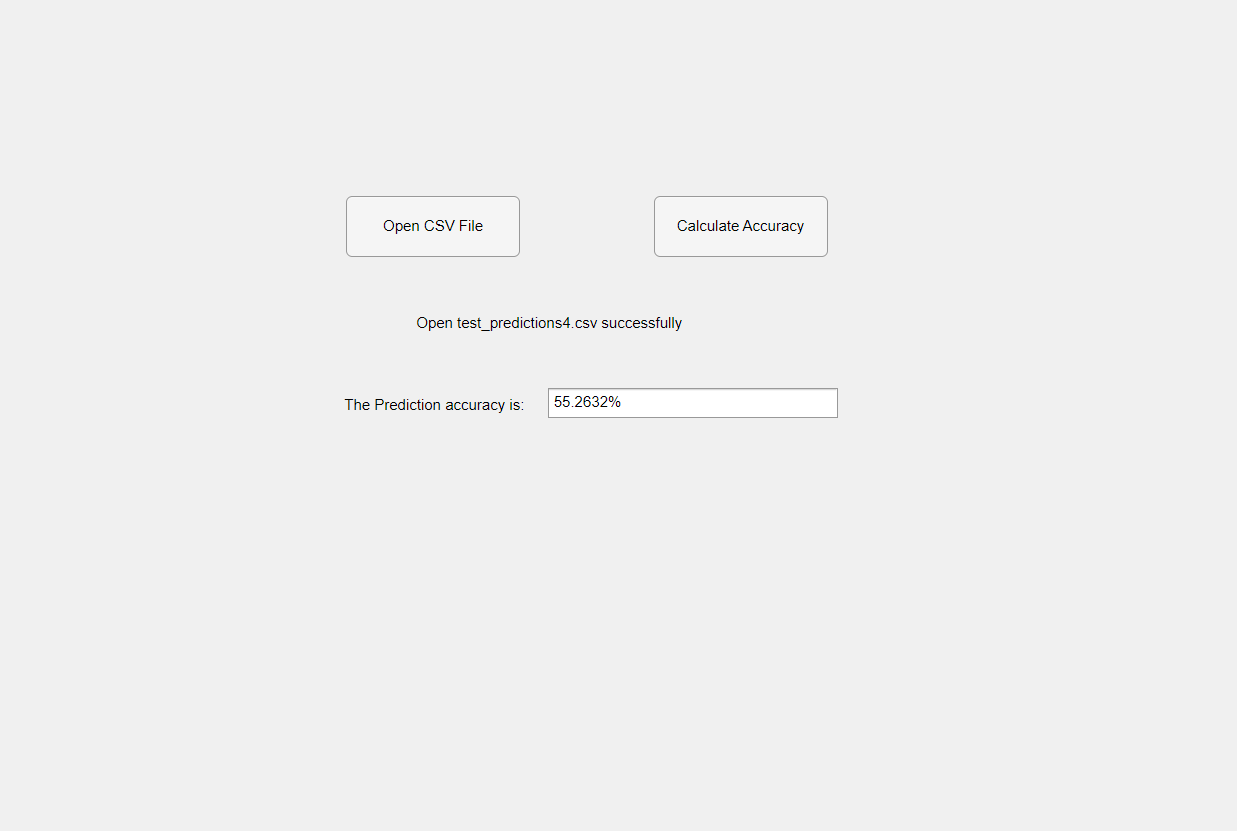